In [ ]:
%pip install langgraph-supervisor langchain-openai langchain

In [1]:
#Initialize the Model
from dotenv import load_dotenv
import os 
from langchain_openai import ChatOpenAI
load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

model = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key)

In [2]:
#Initialize and the tools

def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )


In [3]:
#Initialize the Agents
from langgraph.prebuilt import create_react_agent
math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)



In [4]:
#Creater Supervisor 
from langgraph_supervisor import create_supervisor

# Create supervisor workflow
workflow = create_supervisor(
    agents=[research_agent, math_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "For current events, use research_agent. "
        "For math problems, use math_agent."
    )
)


In [8]:
# Compile and run
from pprint import pprint

app = workflow.compile()
result = app.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Can you get me the headcounts of FAANG companies and then add them together?"
            }
        ]
    },
    config={"configurable": {"return_intermediate_steps": True}},
)
for message in result["messages"]:
    pprint(f"[{message.type}] {message.content}\n")


('[human] Can you get me the headcounts of FAANG companies and then add them '
 'together?\n')
'[ai] \n'
'[tool] Successfully transferred to research_expert\n'
('[ai] Here are the employee headcounts for each of the FAANG companies in '
 '2023:\n'
 '\n'
 '1. **Meta Platforms (Facebook)**: 67,317 employees\n'
 '2. **Apple**: 164,000 employees\n'
 '3. **Amazon**: 1,551,000 employees\n'
 '4. **Netflix**: 14,000 employees\n'
 '5. **Google (Alphabet)**: 181,269 employees\n'
 '\n'
 'To calculate the total headcount, you can simply add these numbers '
 'together.\n')
'[ai] Transferring back to supervisor\n'
'[tool] Successfully transferred back to supervisor\n'
'[ai] \n'
'[tool] Successfully transferred to math_expert\n'
('[ai] The total headcount for the FAANG companies combined is 1,977,586 '
 'employees.\n')
'[ai] Transferring back to supervisor\n'
'[tool] Successfully transferred back to supervisor\n'
('[ai] The total headcount for the FAANG companies combined is 1,977,586 '
 'employees.\

In [9]:
# Just to Get the final output


from pprint import pprint
app = workflow.compile()
# Extract final assistant response
final_output = result.get("messages", [])[-1].content if result.get("messages", []) else "No response"
pprint(final_output)

'The total headcount for the FAANG companies combined is 1,977,586 employees.'


In [12]:
# For Giving the Langgraph 'workflow' is your StateGraph instance
compiled_workflow = workflow.compile()

# Now you can access the graph visualization methods
print(compiled_workflow.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	supervisor(supervisor)
	research_expert(research_expert)
	math_expert(math_expert)
	__end__([<p>__end__</p>]):::last
	__start__ --> supervisor;
	math_expert --> supervisor;
	research_expert --> supervisor;
	supervisor -.-> research_expert;
	supervisor -.-> math_expert;
	supervisor -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



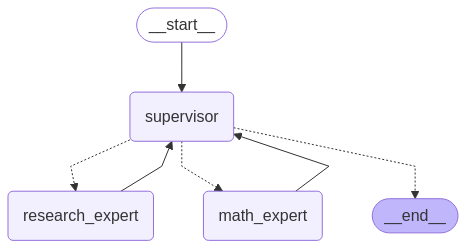

In [17]:

from IPython.display import Image
display(Image(compiled_workflow.get_graph().draw_mermaid_png()))
